## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics
 of their web browser configuration. These characteristics can include the browser type, version, installed plugins,
  and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint
   that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices.
    This has raised concerns about privacy and the potential for this technology
     to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))
 

The columns include:
 - browser
 - os
 - locale
 - user_id
 - location
 - sites
 - time
 - date

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import json
from sklearn.preprocessing import StandardScaler
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('task 1.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20401 entries, 0 to 20400
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     20401 non-null  int64 
 1   browser   20401 non-null  object
 2   os        20401 non-null  object
 3   locale    20401 non-null  object
 4   user_id   20401 non-null  int64 
 5   location  20401 non-null  object
 6   sites     20401 non-null  object
 7   time      20401 non-null  object
 8   date      20401 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [3]:
#Let's analyze the columns in order to determine what preprocessing steps we need to take
data['locale'].value_counts()

ro-RO    1670
bg-BG    1421
en-SG    1403
en-US    1209
nl-NL    1128
en-NZ    1107
xh-ZA    1106
en-CA    1021
ru_RU     985
pt-PT     939
uk-UA     897
pl-PL     709
fr-FR     709
vi-VN     701
ja-JP     625
en-AU     576
zh-CN     534
es-MX     520
it-IT     507
de-DE     504
wo-SN     501
en-GB     494
ru-RU     404
pt-BR     395
ur-PK     336
Name: locale, dtype: int64

In [4]:
data['index'].nunique()
# we can see that this is a unique identifier for each row,
# so we can drop it

20401

In [5]:
data['browser'].value_counts()
# let's check unique values'
# maybe we can one-hot encode it

Chrome               8413
Firefox              6196
Safari               3824
Internet Explorer    1968
Name: browser, dtype: int64

In [6]:
data['os'].value_counts()
#same as "browser"

Windows 10    8345
MacOS         3928
Windows 8     3173
Ubuntu        2076
Windows 7     1742
Debian        1137
Name: os, dtype: int64

In [7]:
data['user_id'].value_counts()

0      400
55     131
82     127
148    122
120    121
      ... 
124     84
145     83
170     82
42      82
152     77
Name: user_id, Length: 200, dtype: int64

In [8]:
data['locale'].value_counts()

ro-RO    1670
bg-BG    1421
en-SG    1403
en-US    1209
nl-NL    1128
en-NZ    1107
xh-ZA    1106
en-CA    1021
ru_RU     985
pt-PT     939
uk-UA     897
pl-PL     709
fr-FR     709
vi-VN     701
ja-JP     625
en-AU     576
zh-CN     534
es-MX     520
it-IT     507
de-DE     504
wo-SN     501
en-GB     494
ru-RU     404
pt-BR     395
ur-PK     336
Name: locale, dtype: int64

In [9]:
data['location'].value_counts()

France/Paris             1625
New Zealand/Auckland     1508
Singapore/Singapore      1279
Germany/Berlin           1247
USA/Chicago              1096
Canada/Toronto           1095
Australia/Sydney         1064
Japan/Tokyo              1063
Canada/Vancouver         1050
UK/London                 935
USA/San Francisco         906
Malaysia/Kuala Lumpur     851
USA/Miami                 837
Spain/Madrid              836
Russia/Moscow             835
Italy/Rome                834
India/Delhi               773
Netherlands/Amsterdam     744
China/Shanghai            667
USA/New York              604
Brazil/Rio de Janeiro     552
Name: location, dtype: int64

In [10]:
def sites_fix(data):
    sites = data['sites']
    sites_with_duplicates = []


    # apply replace .replace("\'", '\"') for each site in sites
    for cur in sites:
       cur = cur.replace("\'", '\"')
       alist = json.loads(cur)

       for i in range(len(alist)):
           site_address = alist[i]['site']
           sites_with_duplicates.append(site_address)

    print("len sites with duplicates: ", len(sites_with_duplicates))

    sites_popular = set()
    for site in sites_with_duplicates:
       if sites_with_duplicates.count(site) > 2:
           sites_popular.add(site)

    print("len sites popular: ", len(sites_popular))

    sites_df = pd.DataFrame(columns=sites_popular)
    data = pd.concat([data, sites_df], axis=1)
    data.fillna(0, inplace=True)

    # if site is in popular sites, then fill it with 1
    for i in range(len(data)):
      cur = data.iloc[i]['sites']
      cur = cur.replace("\'", '\"')
      alist = json.loads(cur)
      for j in range(len(alist)):
        site_address = alist[j]['site']
        if site_address in sites_popular:
            data.at[i, site_address] = 1


    data = data.drop(['sites'], axis=1)
    return data

In [11]:
def preprocess_data(data, is_train, delete_locale):

    #combine date and time to one column
    data['date_time'] = data['date'] + ' ' + data['time']
    data = data.drop(['date', 'time'], axis=1)
    data['date_time'] = pd.to_datetime(data['date_time'])


    # replace ru_RU with ru-RU to be consistent in locale
    data['locale'] = data['locale'].apply(lambda x: x.replace('_', '-'))
    if delete_locale:
        data = data.drop(['locale'], axis=1)


    # Circular encoding for date_time
    # converting date_time to numeric values using cos and sin
    data['time_sin'] = np.sin(2 * np.pi * data['date_time'].dt.hour / 24)
    data['time_cos'] = np.cos(2 * np.pi * data['date_time'].dt.hour / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['date_time'].dt.day / 31)
    data['day_cos'] = np.cos(2 * np.pi * data['date_time'].dt.day / 31)
    data['month_sin'] = np.sin(2 * np.pi * data['date_time'].dt.month / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['date_time'].dt.month / 12)
    data['year_sin'] = np.sin(2 * np.pi * data['date_time'].dt.year / 2021)
    data['year_cos'] = np.cos(2 * np.pi * data['date_time'].dt.year / 2021)
    data = data.drop(['date_time'], axis=1)



    if is_train:
        # Let's drop indexes and user_id
        # And introduce a new column "is_waldo" which will be 1 if user_id is 0
        # Waldo is our target user

        data = data.drop(['index'], axis=1)
        # identify is it user 0 or not
        data['is_waldo'] = data['user_id'].apply(lambda x: 1 if x == 0 else 0)
        data = data.drop(['user_id'], axis=1)



    # one hot encoding for browser, os, locale
    if delete_locale:
        data = pd.get_dummies(data, columns=['browser', 'os', 'location'])
    else:
        data = pd.get_dummies(data, columns=['browser', 'os', 'locale', 'location'])

    data = sites_fix(data)

    scaler = StandardScaler()
    data[['time_sin', 'time_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'year_sin',
      'year_cos']] = scaler.fit_transform(
    data[['time_sin', 'time_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos']])

    return data

In [12]:
# "location" and "locale" seem to be dependent, let's check it

# Chi-Square Test for Independence for "locale" and "location"
# H0: locale and location are independent
# H1: locale and location are not independent
# make conclusions based on results


contingency_table = pd.crosstab(data['locale'], data['location'])
print(contingency_table)

stat, p, dof, expected = chi2_contingency(contingency_table)
print('dof=%d' % dof)
print(expected)

prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))

if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

location  Australia/Sydney  Brazil/Rio de Janeiro  Canada/Toronto  \
locale                                                              
bg-BG                   73                     38              73   
de-DE                   26                      8              33   
en-AU                   26                     15              29   
en-CA                   44                     33              47   
en-GB                   26                     13              28   
en-NZ                   55                     33              48   
en-SG                   76                     30              75   
en-US                   59                     33              79   
es-MX                   30                     19              25   
fr-FR                   37                     18              25   
it-IT                   30                     20              24   
ja-JP                   32                     22              33   
nl-NL                   64        

In [13]:
data = preprocess_data(data, True, True)

len sites with duplicates:  157661
len sites popular:  4078


In [14]:
validation = pd.read_csv('task_1_verify.csv')
validation = preprocess_data(validation, False, True)

len sites with duplicates:  259
len sites popular:  27


In [15]:
data.shape, validation.shape

((20401, 4118), (36, 62))

In [16]:
# find columns that is presented in both data and validation
# and drop columns that are not presented in both, except is_waldo column
data_columns = data.columns
validation_columns = validation.columns
intersection = set(data_columns) & set(validation_columns)
data = data[list(intersection) + ['is_waldo']]
validation = validation[list(intersection)]

In [17]:
set(data.columns) - set(validation.columns)

{'is_waldo'}

In [18]:
#check shapes
data.shape, validation.shape

((20401, 63), (36, 62))

In [19]:
# start creating ANN

In [20]:
# Activation function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [21]:
# Splitting the data into train and test
X = data.drop(['is_waldo'], axis=1).values
y = data['is_waldo'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [22]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# Our DATASET is unbalanced, so we need to use F1 score as metric
data['is_waldo'].value_counts(normalize=True)

0    0.980393
1    0.019607
Name: is_waldo, dtype: float64

In [24]:
tf.random.set_seed(17)
#find gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
# Check shapes again
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16320, 62), (4081, 62), (16320,), (4081,))

In [26]:
# create f1 score function for keras model to pass as metrics
def f1(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

In [27]:
Fine-tuning the model, custom GridSearch... TO GET THE BEST MODEL
activations = ['relu', 'sigmoid', 'tanh', 'elu']
optimizers = [tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.01),
              tf.keras.optimizers.Adam(learning_rate=0.0001), tf.keras.optimizers.SGD(learning_rate=0.001),
              tf.keras.optimizers.SGD(learning_rate=0.01), tf.keras.optimizers.SGD(learning_rate=0.0001)]

for activation in activations:
    for optimizer in optimizers:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation=activation, input_shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(256, activation=activation),
            tf.keras.layers.Dense(32, activation=activation),
            tf.keras.layers.Dense(16, activation=activation),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=[f1, 'accuracy'])
        model.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0, validation_data=(X_test, y_test))
        y_pred = model.predict(X_test, batch_size=128, verbose=0)
        print(f'Activation: {activation}, Optimizer: {optimizer}, F1: {f1_score(y_test, y_pred.round())}')

In [28]:
# Chosen best model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[f1, 'accuracy'])

In [30]:
model.fit(X_train, y_train, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
128/128 [==============================] - 3s 6ms/step - loss: 0.0487 - f1: 0.4398 - accuracy: 0.9868
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 2.5508e-04 - f1: 0.9219 - accuracy: 1.0000
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 4.0554e-05 - f1: 0.9141 - accuracy: 1.0000
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.7525e-05 - f1: 0.9375 - accuracy: 1.0000
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0516e-05 - f1: 0.9297 - accuracy: 1.0000
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 6.9301e-06 - f1: 0.9141 - accuracy: 1.0000
Epoch 7/100
128/128 [==============================] - 1s 6ms/step - loss: 4.9248e-06 - f1: 0.9062 - accuracy: 1.0000
Epoch 8/100
128/128 [==============================] - 1s 6ms/step - loss: 3.6986e-06 - f1: 0.9531 - accuracy: 1.0000
Epoch 9/100
128/128 [==============================] - 1s 6m

In [31]:
from sklearn.metrics import classification_report

# make classification report for test data
y_pred = model.predict(X_test, batch_size=128, verbose=1)
print(classification_report(y_test, y_pred.round()))

32/32 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4007
           1       1.00      1.00      1.00        74

    accuracy                           1.00      4081
   macro avg       1.00      1.00      1.00      4081
weighted avg       1.00      1.00      1.00      4081


In [32]:
y_pred = model.predict(validation, batch_size=128, verbose=1)
print(y_pred.round())

1/1 [==============================] - 0s 113ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [36]:
#print results in form of "row_id : is_waldo"
y_pred = y_pred.round()
for i in range(len(y_pred)):
    print(f'{i} : {int(y_pred[i][0])}')


0 : 0
1 : 0
2 : 0
3 : 0
4 : 0
5 : 0
6 : 0
7 : 0
8 : 0
9 : 0
10 : 0
11 : 0
12 : 0
13 : 0
14 : 0
15 : 0
16 : 0
17 : 0
18 : 0
19 : 0
20 : 0
21 : 0
22 : 0
23 : 0
24 : 0
25 : 0
26 : 0
27 : 0
28 : 0
29 : 0
30 : 0
31 : 1
32 : 1
33 : 1
34 : 1
35 : 1


Fingerprint Recognition
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In [13]:
import os
import tensorflow as tf
import imghdr
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# let gpu use memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [44]:
#create new folder "images_data" to store images
if not os.path.exists("images_data"):
    os.mkdir("images_data")

In [45]:
#unzip task_2.zip to the new folder "images_data"
import zipfile

with zipfile.ZipFile('task 2.zip', 'r') as zip_ref:
    zip_ref.extractall("images_data")

zip_ref.close()

In [46]:
#create new folders "train_images" and "test_images" to store images in "images_data" folder
if not os.path.exists("images_data/train_images"):
    os.mkdir("images_data/train_images")
if not os.path.exists("images_data/test_images"):
    os.mkdir("images_data/test_images")

In [47]:
# unzip train.zip to the new folder "train_images"
import zipfile

with zipfile.ZipFile('images_data/train.zip', 'r') as zip_ref:
    zip_ref.extractall("images_data/train_images")

zip_ref.close()

In [48]:
# unzip test.zip to the new folder "test_images"
import zipfile

with zipfile.ZipFile('images_data/test.zip', 'r') as zip_ref:
    zip_ref.extractall("images_data/test_images")

zip_ref.close()

In [49]:
#delete train.zip and test.zip
os.remove("images_data/train.zip")
os.remove("images_data/test.zip")

In [50]:
# convert images to bmp format
for image in os.listdir("images_data/train_images/train"):
    image_path = os.path.join("images_data/train_images/train", image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)

    except Exception as e:
        print("Issue with image {}".format(image_path))

In [51]:
# show image count in folder "train_images/train"
print(len(os.listdir("images_data/train_images/train")))

19413


In [52]:
# show image count in folder "test_images/content/test"
print(len(os.listdir("images_data/test_images/content/test")))

14272


In [53]:
# same for test data
for image in os.listdir("images_data/test_images/content/test"):
    image_path = os.path.join("images_data/test_images/content/test", image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)

    except Exception as e:
        print("Issue with image {}".format(image_path))

In [54]:
# check some image
image_temp = cv2.imread("images_data/train_images/train/4_3.BMP")

In [55]:
type(image_temp)

numpy.ndarray

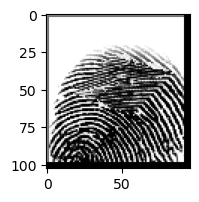

In [56]:
# plot image
from matplotlib import pyplot as plt
plt.figure(figsize=(2,2))
plt.imshow(cv2.cvtColor(image_temp, cv2.COLOR_BGR2RGB))
plt.show()

### ------------------------------ LOAD DATA ---------------------------

In [57]:
# in "images_data/train_images/train" folder create new folders from 0 to 9
for i in range(10):
    if not os.path.exists("images_data/train_images/train/{}".format(i)):
        os.mkdir("images_data/train_images/train/{}".format(i))

In [58]:
# for each image in "images_data/train_images/train" folder move it to the folder with the same name as the label
for image in os.listdir("images_data/train_images/train"):
    image_path = os.path.join("images_data/train_images/train", image)
    parts = image.split("_")
    if len(parts) == 2:
        label = parts[1].split(".")[0]
        os.rename(image_path, os.path.join("images_data/train_images/train/{}".format(label), image))

In [59]:
# do same for the test data
for i in range(10):
    if not os.path.exists("images_data/test_images/content/test/{}".format(i)):
        os.mkdir("images_data/test_images/content/test/{}".format(i))

In [60]:
for image in os.listdir("images_data/test_images/content/test"):
    image_path = os.path.join("images_data/test_images/content/test", image)
    parts = image.split("_")
    if len(parts) == 2:
        label = parts[1].split(".")[0]
        os.rename(image_path, os.path.join("images_data/test_images/content/test/{}".format(label), image))

#### LOAD DATA

In [80]:
train_imgs = tf.keras.utils.image_dataset_from_directory(
    "images_data/train_images/train",
    labels="inferred",
    label_mode="int",
    shuffle=True,
    seed=17,
    batch_size=32,
    image_size=(300,300),
)

Found 19413 files belonging to 10 classes.


In [81]:
# make same process for test data, but consider that their extension is unknown. but it's possible to read them as .bmp

# rename all files in test to .bmp extension
for folder in os.listdir("images_data/test_images/content/test"):
    folder_path = os.path.join("images_data/test_images/content/test", folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        os.rename(image_path, image_path + ".bmp")


In [82]:
import os
# if there's  any file not in .bmp extension, delete it
for folder in os.listdir("images_data/test_images/content/test"):
    folder_path = os.path.join("images_data/test_images/content/test", folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        if not image_path.endswith(".bmp"):
            os.remove(image_path)

In [83]:
import tensorflow as tf

test_imgs = tf.keras.utils.image_dataset_from_directory(
    "images_data/test_images/content/test",
    labels="inferred",
    label_mode="int",
    shuffle=True,
    seed=17,
    batch_size=32,
    image_size=(300,300),
)

Found 14272 files belonging to 10 classes.


In [84]:
train_imgs.class_names, test_imgs.class_names

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [85]:
from keras.layers import Cropping2D
# delete borders
train_imgs = train_imgs.map(lambda x, y: (Cropping2D(cropping=((8,12), (5,12)))(x), y))
test_imgs = test_imgs.map(lambda x, y: (Cropping2D(cropping=((8,12), (5,12)))(x), y))

In [86]:
train_iterator = train_imgs.as_numpy_iterator()
test_iterator = test_imgs.as_numpy_iterator()

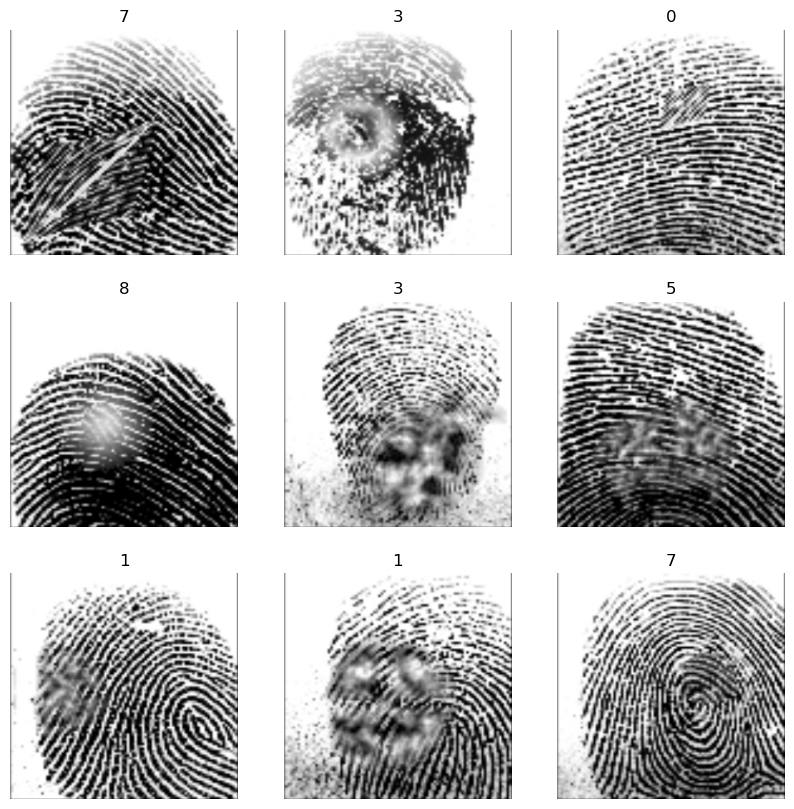

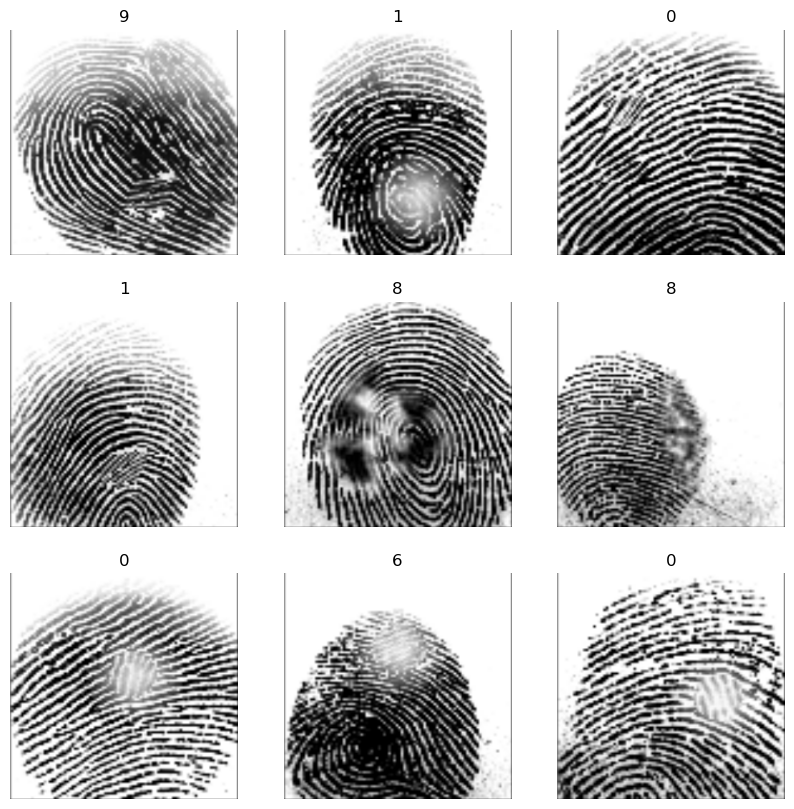

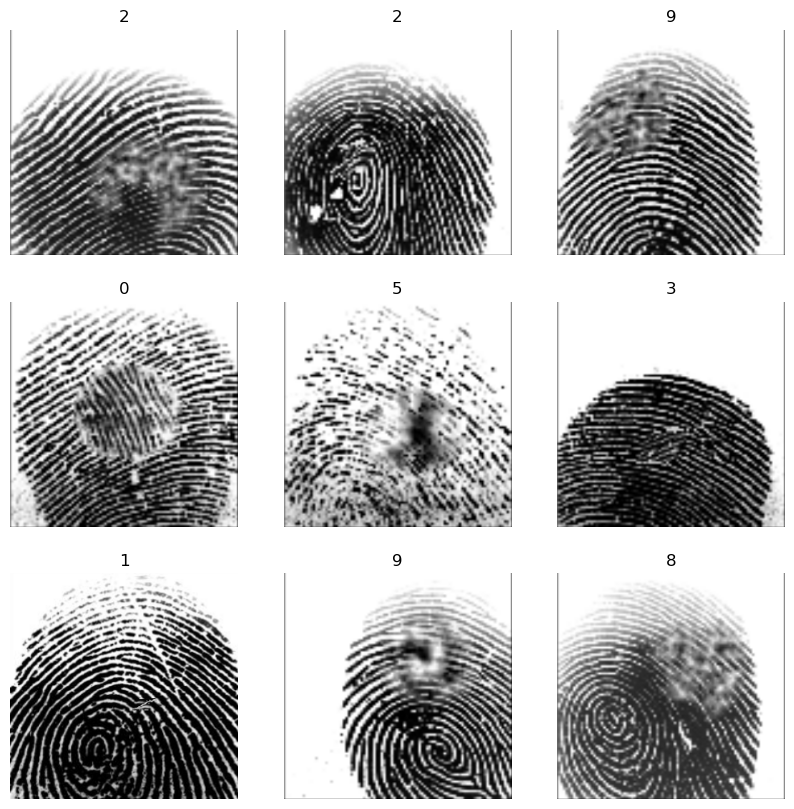

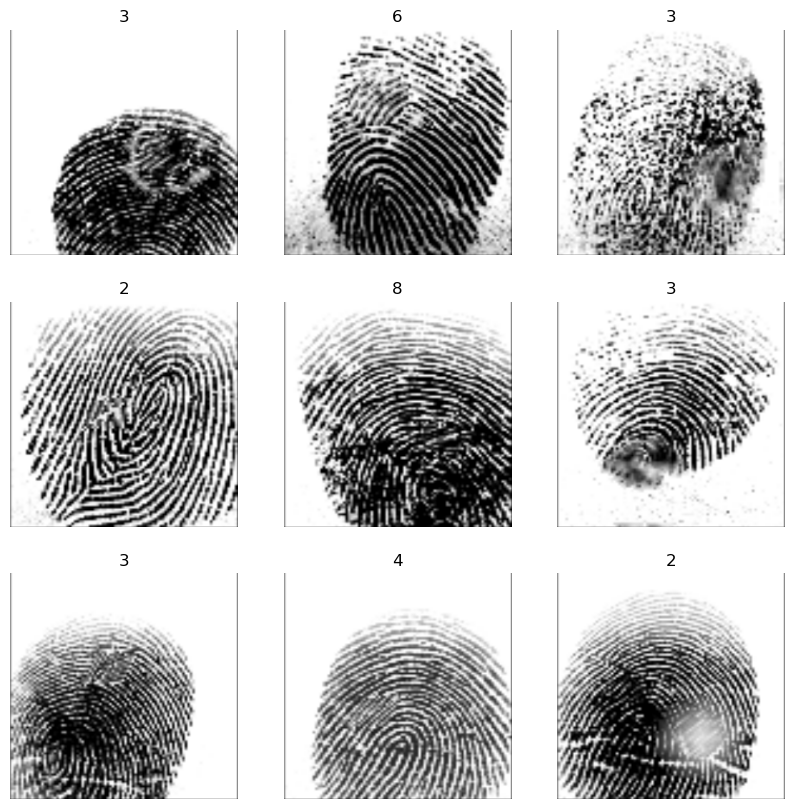

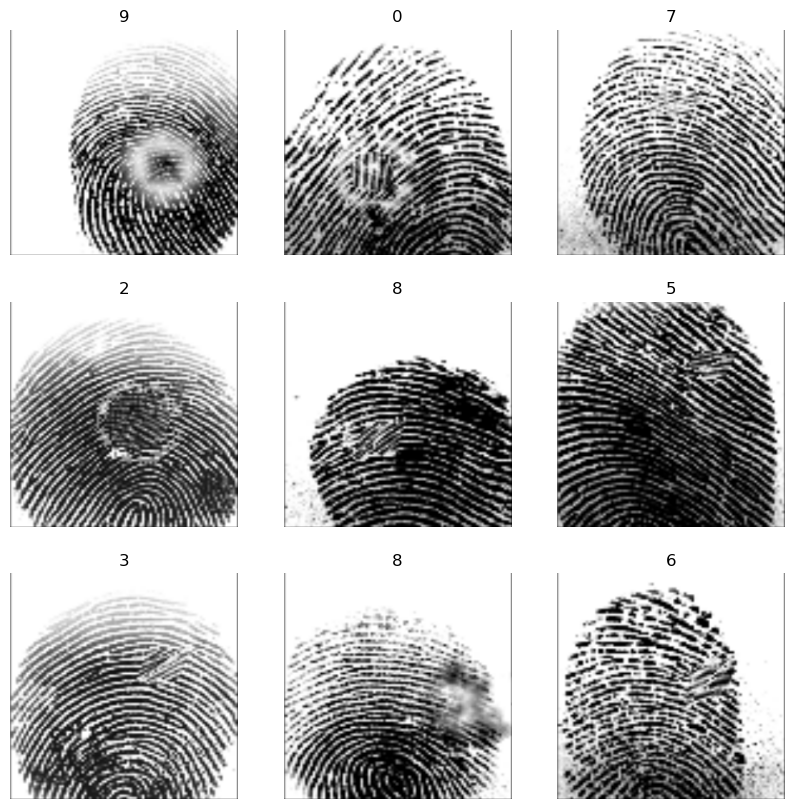

In [87]:
# show some images
for i in range(5):
    batch = next(train_iterator)
    plt.figure(figsize=(10,10))
    for j in range(9):
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(batch[0][j].astype("uint8"))
        plt.title(batch[1][j])
        plt.axis("off")
    plt.show()

### PREPROCESSING

##### SCALE

In [88]:
train = train_imgs.map(lambda x, y: (tf.image.per_image_standardization(x), y))
test = test_imgs.map(lambda x, y: (tf.image.per_image_standardization(x), y))

In [89]:
batch = next(train.as_numpy_iterator())
batch[0].shape

(32, 280, 283, 3)

#### SPLIT

In [90]:
# TRAIN AND VALID is used to learn, TEST is used to evaluate the model
train_size = int(0.8 * len(train))
val_size = int(0.2 * len(train))

In [91]:
len(train)

607

In [92]:
train_size, val_size

(485, 121)

In [93]:
len(test)

446

In [94]:
train_new = train.take(train_size)
val_new = train.skip(train_size).take(val_size)

In [95]:
len(train_new), len(val_new)

(485, 121)

## BUILDING MODEL

##### 1. BUILDING DNN

In [96]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import torch
#import necessary libraries for image transformations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi

In [97]:
# show number of gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [98]:
# image transformations as flip, rotation, noise, blur, change of perspective, etc
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(300, 300, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

In [99]:
model = Sequential(
    [
        data_augmentation,
        Conv2D(64, (5, 5), 1, activation="relu", input_shape=(280,283,3)),
        MaxPooling2D(),
        Conv2D(32, (3, 3), 1, activation="relu"),
        MaxPooling2D(),
        Conv2D(20, (2, 2), 1, activation="relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation="relu"),
        # Dropout(0.5),
        Dense(10, activation="softmax"),
    ]
)

In [100]:

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [101]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 276, 279, 64)      4864      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 138, 139, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 136, 137, 32)      18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 68, 68, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 67, 67, 20)        2580      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 33, 33, 20)      

### BAAM ! TRAIN PART

In [102]:
# fit the model using data augmentation
history = model.fit(
    train_new,
    validation_data=val_new,
    epochs=20,
)

Epoch 1/20
485/485 [==============================] - 133s 271ms/step - loss: 1.2618 - accuracy: 0.5617 - val_loss: 0.7652 - val_accuracy: 0.7433
Epoch 2/20
485/485 [==============================] - 127s 262ms/step - loss: 0.3234 - accuracy: 0.8963 - val_loss: 0.4175 - val_accuracy: 0.8993
Epoch 3/20
485/485 [==============================] - 127s 261ms/step - loss: 0.0943 - accuracy: 0.9707 - val_loss: 0.3160 - val_accuracy: 0.9277
Epoch 4/20
485/485 [==============================] - 127s 261ms/step - loss: 0.0522 - accuracy: 0.9856 - val_loss: 0.2679 - val_accuracy: 0.9481
Epoch 5/20
485/485 [==============================] - 127s 261ms/step - loss: 0.0448 - accuracy: 0.9869 - val_loss: 0.3644 - val_accuracy: 0.9166
Epoch 6/20
485/485 [==============================] - 127s 261ms/step - loss: 0.0619 - accuracy: 0.9818 - val_loss: 0.5273 - val_accuracy: 0.9029
Epoch 7/20
485/485 [==============================] - 127s 261ms/step - loss: 0.0620 - accuracy: 0.9804 - val_loss: 0.3960 -

### PLOT PERFORMANCE

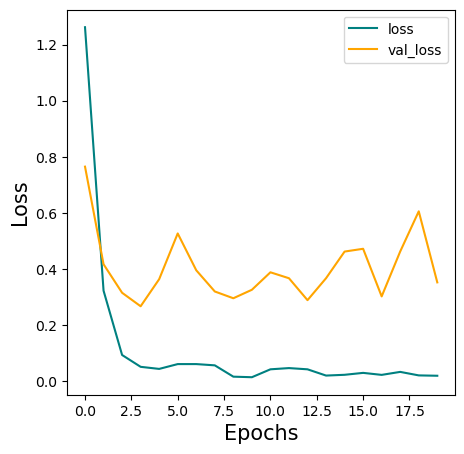

In [103]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(5, 5))
plt.plot(history.history["loss"], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.show()

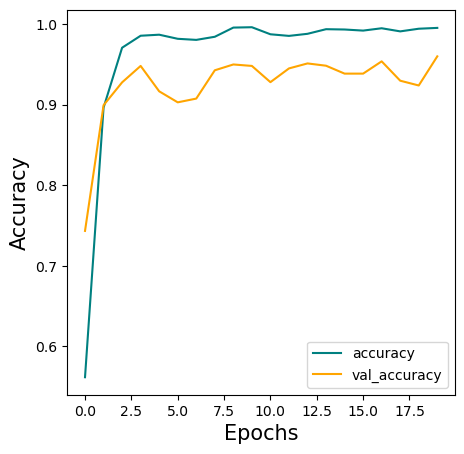

In [104]:
# plot accuracy as the same
fig = plt.figure(figsize=(5, 5))
plt.plot(history.history["accuracy"], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

### EVALUATION

In [105]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [106]:
len(test)

446

In [107]:
# calculate accuracy on test set
y_actual = []
y_pred = []

for batch in test.as_numpy_iterator():
    y_actual.extend(batch[1])
    y_pred.extend(np.argmax(model.predict(batch[0]), axis=1))

correct = 0
for i in range(len(y_actual)):
    if y_actual[i] == y_pred[i]:
        correct += 1

print("Accuracy: ", correct/len(y_actual))

1/1 [==============================] - 0s 37ms/step
Accuracy:  0.9291619955156951
